In [ ]:
# Remove repo in local Colab storage if needed
!rm -r Differential-Equation-Solutions-with-Multilayer-Perceptron

rm: cannot remove 'Differential-Equation-Solutions-with-Multilayer-Perceptron': No such file or directory


In [2]:
# clone repo if we don't have in this session, specify branch after -b
!git clone -b main https://github.com/thesullivantage/Differential-Equation-Solutions-with-Multilayer-Perceptron
# if already exists, just pull in next cell

Cloning into 'Differential-Equation-Solutions-with-Multilayer-Perceptron'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 151 (delta 76), reused 136 (delta 69), pack-reused 0
Receiving objects: 100% (151/151), 33.75 KiB | 2.41 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [17]:
# Update (pull) repo from branch of our choosing
!cd Differential-Equation-Solutions-with-Multilayer-Perceptron && git checkout main && git pull

Already on 'main'
Your branch is up to date with 'origin/main'.
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6 (delta 2), reused 6 (delta 2), pack-reused 0
Unpacking objects: 100% (6/6), 1.82 KiB | 930.00 KiB/s, done.
From https://github.com/thesullivantage/Differential-Equation-Solutions-with-Multilayer-Perceptron
   06b15c8..5f58c66  main       -> origin/main
Updating 06b15c8..5f58c66
Fast-forward
 .gitignore         |  1 +
 mlp_de_training.py | 79 ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 model_pk/loss.py   | 17 ++++++++++------
 run_train.py       | 71 ------------------------------------------------------------------
 4 files changed, 91 insertions(+), 77 deletions(-)
 create mode 100644 mlp_de_training.py
 delete mode 100644 run_train.py


In [18]:
import sys
import os
from importlib import reload

In [19]:
sys.path.insert(0, 'Differential-Equation-Solutions-with-Multilayer-Perceptron')

In [20]:
# to reload modules as we make changes
reload(loss)
reload(model)


<module 'model_pk.model' from '/content/Differential-Equation-Solutions-with-Multilayer-Perceptron/model_pk/model.py'>

In [21]:
import model_pk
from model_pk import loss, model

In [22]:
import sys
import tensorflow.keras as keras
import tensorflow as tf

In [35]:
f0=0

In [71]:
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
mlp = model.MLP(num_embed_layer=3, phys_dimension=1,embed_dim=64)
loss_fn = loss.LossODE(f0=f0, dell=None) # default del_x



In [72]:
# Make simple ODE domain for f'(x) = 2x: STANDARDIZED OR NORMALIZED
phys_dimension = 1
# Range of independent variable values on unit norm interval
start = 0  # Start value
limit = 1  # End value (exclusive)
delta = 0.001  # Step size

# Create a TensorFlow array in the style of np.arange
inputs = tf.reshape(tf.range(start, limit, delta, dtype=tf.float32), (-1, phys_dimension))


In [ ]:
# # Training loop
# num_epochs = 25  # Define the number of epochs

# ### Trained using SGD optimization (MSE), without replacement
# ### n (dim. inputs) gradient updates
# for epoch in range(1, num_epochs+1):
#     ### increment squared loss over entire epoch (dataset)
#     epoch_total_loss = 0
#     for input_example in inputs:
#         # seems easiest to resize individual data points
#         input_example_reshaped = tf.reshape(input_example, (1,1))
#         with tf.GradientTape() as tape:
#             # Compute the loss for the current input example (squared error)
#             loss_curr = loss_fn.compute_loss_element(mlp, input_example_reshaped)
#             print('LOSS SNAPSHOT: ', loss_curr)
#             epoch_total_loss += loss_curr
#         # Compute gradients and update model parameters
#         gradients = tape.gradient(loss_curr, mlp.trainable_variables)
#         optimizer.apply_gradients(zip(gradients, mlp.trainable_variables))
#     epoch_avg_loss = epoch_total_loss / tf.cast(inputs.shape[0], tf.float32)
#     print(f'Epoch {epoch} Average Loss: ', epoch_avg_loss[0][0])

In [73]:
### batched training with Adam
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

In [74]:
dataset = tf.data.Dataset.from_tensor_slices(inputs)
batch_size = 32 # Choose an appropriate batch size
dataset = dataset.batch(batch_size)

In [ ]:
num_epochs = 50

for epoch in range(1, num_epochs + 1):
    epoch_total_loss = 0
    num_batches = 0

    for batch in dataset:
        with tf.GradientTape() as tape:
            batch_loss = loss_fn.mse_all_batch(mlp, batch)
            epoch_total_loss += tf.reduce_sum(batch_loss)
            num_batches += 1

        gradients = tape.gradient(batch_loss, mlp.trainable_variables)
        optimizer.apply_gradients(zip(gradients, mlp.trainable_variables))

    epoch_avg_loss = epoch_total_loss / (num_batches * batch_size)
    print(f'Epoch {epoch}, Average Loss: {epoch_avg_loss.numpy()}')


Epoch 1, Average Loss: 0.019402693957090378
Epoch 2, Average Loss: 0.018797779455780983
Epoch 3, Average Loss: 0.017422573640942574
Epoch 4, Average Loss: 0.014135649427771568
Epoch 5, Average Loss: 0.010121641680598259
Epoch 6, Average Loss: 0.008467971347272396
Epoch 7, Average Loss: 0.008163152262568474
Epoch 8, Average Loss: 0.007886017672717571
Epoch 9, Average Loss: 0.0074896072037518024
Epoch 10, Average Loss: 0.006954866461455822
Epoch 11, Average Loss: 0.006303055211901665
Epoch 12, Average Loss: 0.005506617482751608


In [39]:
import matplotlib
import matplotlib.pyplot as plt

In [67]:
def analytic_solution(inputs, f0=0):
  return inputs**2 + f0

In [68]:
inputs_np = inputs.numpy()
mlp_outputs_np = loss_fn.approx_eval(mlp, inputs_np)
analy_outputs_np = analytic_solution(inputs_np, f0=f0)

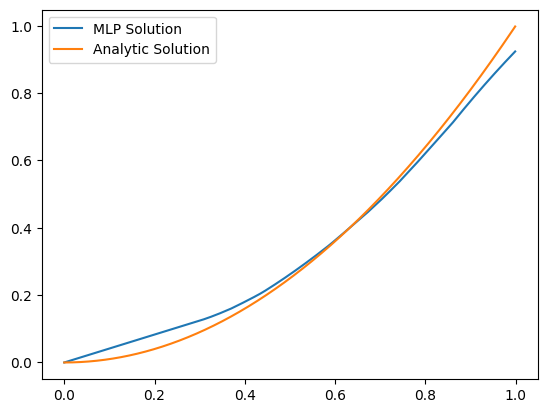

In [70]:
plt.plot(inputs_np, mlp_outputs_np, label='MLP Solution')
plt.plot(inputs_np, analy_outputs_np, label='Analytic Solution')
plt.legend()
plt.show()